In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import glob
import random
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, Add, Activation, MaxPool2D, concatenate, LeakyReLU, SpatialDropout2D


In [ ]:
SIZE_X = 256
SIZE_Y = 256
n_classes=7
num_images = 300

In [ ]:
image_names = glob.glob('dataset/data_for_training_and_testing/image/*.jpg')
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [
    cv2.cvtColor(cv2.imread(image, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    for image in image_names_subset
]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)
image_dataset

array([[[[[ 88,  83,  63]],

         [[ 90,  85,  65]],

         [[ 90,  85,  65]],

         ...,

         [[ 59,  77,  51]],

         [[ 55,  73,  47]],

         [[ 59,  77,  51]]],


        [[[ 90,  85,  65]],

         [[ 87,  82,  62]],

         [[ 87,  82,  62]],

         ...,

         [[ 57,  75,  49]],

         [[ 58,  76,  50]],

         [[ 62,  80,  54]]],


        [[[ 91,  86,  66]],

         [[ 88,  83,  63]],

         [[ 89,  84,  64]],

         ...,

         [[ 58,  76,  52]],

         [[ 62,  82,  57]],

         [[ 62,  82,  57]]],


        ...,


        [[[112,  94,  70]],

         [[103,  85,  61]],

         [[100,  82,  58]],

         ...,

         [[ 85,  80,  58]],

         [[ 86,  81,  61]],

         [[ 88,  83,  63]]],


        [[[113,  95,  71]],

         [[109,  91,  67]],

         [[106,  88,  64]],

         ...,

         [[ 87,  82,  60]],

         [[ 84,  79,  59]],

         [[ 86,  81,  61]]],


        [[[106,  88,  64]],

 

In [ ]:
mask_names = glob.glob('dataset/data_for_training_and_testing/mask/*.png')
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset

array([[[225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        ...,
        [105, 105, 105, ..., 105, 105, 105],
        [105, 105, 105, ..., 105, 105, 105],
        [105, 105, 105, ..., 105, 105, 105]],

       [[225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        ...,
        [225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225]],

       [[225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        ...,
        [225, 225, 225, ..., 105, 105, 105],
        [225, 225, 225, ..., 105, 105, 105],
        [225, 225, 225, ..., 105, 105, 105]],

       ...,

       [[ 29,  29,  29, ...,  29,  29,  29],
        [ 29,  29,  29, ...,  29,  29,  29],
        [ 29,  29,  29, ...,  29,  29,  29

In [6]:
print("Image data shape :", image_dataset.shape)
print("Mask data shape :", mask_dataset.shape)
print("Maximum pixel value in images :", image_dataset.max())
print("Labels in masks :", np.unique(mask_dataset))
print("Number of labels :", len(np.unique(mask_dataset)))

Image data shape : (300, 256, 256, 1, 3)
Mask data shape : (300, 256, 256)
Maximum pixel value in images : 255
Labels in masks : [  0  29 105 149 178 225 255]
Number of labels : 7


In [ ]:
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6])

In [8]:
label_to_land_type = {
    0: "unknown",
    1: "water",
    2: "rangeland",
    3: "forest_land",
    4: "urban_land",
    5: "agriculture_land",
    6: "barren_land"
}

In [9]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(300, 256, 256, 1)


In [10]:
image_dataset = image_dataset / 255.
image_dataset

array([[[[[0.34509804, 0.3254902 , 0.24705882]],

         [[0.35294118, 0.33333333, 0.25490196]],

         [[0.35294118, 0.33333333, 0.25490196]],

         ...,

         [[0.23137255, 0.30196078, 0.2       ]],

         [[0.21568627, 0.28627451, 0.18431373]],

         [[0.23137255, 0.30196078, 0.2       ]]],


        [[[0.35294118, 0.33333333, 0.25490196]],

         [[0.34117647, 0.32156863, 0.24313725]],

         [[0.34117647, 0.32156863, 0.24313725]],

         ...,

         [[0.22352941, 0.29411765, 0.19215686]],

         [[0.22745098, 0.29803922, 0.19607843]],

         [[0.24313725, 0.31372549, 0.21176471]]],


        [[[0.35686275, 0.3372549 , 0.25882353]],

         [[0.34509804, 0.3254902 , 0.24705882]],

         [[0.34901961, 0.32941176, 0.25098039]],

         ...,

         [[0.22745098, 0.29803922, 0.20392157]],

         [[0.24313725, 0.32156863, 0.22352941]],

         [[0.24313725, 0.32156863, 0.22352941]]],


        ...,


        [[[0.43921569, 0.36862745,

In [11]:
image_dataset = image_dataset.reshape((image_dataset.shape[0], image_dataset.shape[1], image_dataset.shape[2], image_dataset.shape[4]))
print("Fixed image_dataset shape:", image_dataset.shape)

Fixed image_dataset shape: (300, 256, 256, 3)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [13]:
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print(y_train_cat.shape)

(240, 256, 256, 7)


In [14]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print('Input Shape :', input_shape)

Input Shape : (256, 256, 3)


In [ ]:
print("X_train shape:", X_train.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("X_test shape:", X_test.shape)
print("y_test_cat shape:", y_test_cat.shape)

X_train shape: (240, 256, 256, 3)
y_train_cat shape: (240, 256, 256, 7)
X_test shape: (60, 256, 256, 3)
y_test_cat shape: (60, 256, 256, 7)


In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        ce_loss = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * ce_loss, axis=-1)
    return loss

def combined_loss(y_true, y_pred):
    loss_ce = CategoricalCrossentropy()(y_true, y_pred)
    loss_dice = dice_loss(y_true, y_pred)
    loss_focal = focal_loss()(y_true, y_pred)
    return 0.4 * loss_ce + 0.4 * loss_dice + 0.2 * loss_focal

In [17]:
def plot_training_history(history, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Accuracy over Epoch', fontweight='bold', fontsize=14)
    axes[0].set_ylabel('Accuracy', fontweight='bold', fontsize=12)
    axes[0].set_xlabel('Epoch', fontweight='bold', fontsize=12)
    axes[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Loss over Epoch', fontweight='bold', fontsize=14)
    axes[1].set_ylabel('Loss', fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Epoch', fontweight='bold', fontsize=12)
    axes[1].legend(['Training Loss', 'Validation Loss'], loc='upper right')

    plt.suptitle(f'{title}', fontweight='bold', fontsize=16)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [ ]:
def visualize_predictions(model, num_images=10):
    for i in range(num_images):
        test_img_number = random.randint(0, len(X_test) - 1)
        test_img = X_test[test_img_number]
        ground_truth = y_test[test_img_number]

        test_img_input = np.expand_dims(test_img, 0)

        prediction = model.predict(test_img_input)

        predicted_img = np.argmax(prediction, axis=3)[0, :, :]

        ground_truth_img = ground_truth[:, :, 0]

        plt.figure(figsize=(12, 8))

        plt.subplot(231)
        plt.title('Testing Image')
        plt.imshow(test_img)

        plt.subplot(232)
        plt.title('Testing Label')
        plt.imshow(ground_truth_img)

        plt.subplot(233)
        plt.title('Prediction on test image')
        plt.imshow(predicted_img)

        plt.show()

In [ ]:
def evaluate_model_performance(model, n_classes=7):
    IOU_keras = MeanIoU(num_classes=n_classes)

    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=-1)

    IOU_keras.update_state(y_test[:, :, :, 0], y_pred_class)
    print("Mean IoU :", IOU_keras.result().numpy())

    y_true = y_test[:, :, :, 0].flatten()
    y_pred = y_pred_class.flatten()

    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

    class_labels = [label_to_land_type[i] for i in range(n_classes)]

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix', weight='bold')
    plt.xlabel('Predicted Labels', weight='bold')
    plt.ylabel('True Labels', weight='bold')
    plt.legend(prop={'weight': 'bold'})
    plt.show()

    IoU_per_class = []
    for i in range(n_classes):
        TP = conf_matrix[i, i]
        FP = np.sum(conf_matrix[:, i]) - TP
        FN = np.sum(conf_matrix[i, :]) - TP
        IoU = TP / (TP + FP + FN) if (TP + FP + FN) != 0 else 0
        IoU_per_class.append(IoU)

    for i in range(n_classes):
        print(f"IoU for Class '{label_to_land_type[i]}' : {IoU_per_class[i]:.4f}")

U-Net

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = SpatialDropout2D(0.1)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(num_filters, 1, padding="same")(input)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = LeakyReLU(alpha=0.1)(x)

    return x

def encoder_block(input, num_filters, dropout_rate=0.3):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    p = Dropout(dropout_rate)(p)
    return x, p

def attention_block(x, g, num_filters):
    theta_x = Conv2D(num_filters, 1, padding="same")(x)
    phi_g = Conv2D(num_filters, 1, padding="same")(g)
    attn_map = Activation('relu')(Add()([theta_x, phi_g]))
    attn_map = Conv2D(1, 1, activation='sigmoid', padding="same")(attn_map)
    return x * attn_map

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 3, strides=(2, 2), padding="same")(input)
    skip_features = attention_block(skip_features, x, num_filters)

    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def bottleneck(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", dilation_rate=2)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(num_filters, 3, padding="same", dilation_rate=2)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    return x

def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = bottleneck(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)

    model = Model(inputs, outputs, name="U-Net-Enhanced")
    return model

optimizer = Adam(learning_rate=0.001, weight_decay=1e-4)

model_UNet = build_unet(input_shape, n_classes=7)
model_UNet.compile(optimizer=optimizer, loss=combined_loss, metrics=['accuracy'])
model_UNet.summary()

Model: "U-Net-Enhanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_34    │ (None, 256, 256, 64)   │            256 │ conv2d_47[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_26            │ (None, 256, 256, 64)   │              0 │ batch_normalization_3… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_8       │ (None, 256, 256, 64)   │              0 │ leaky_re_lu_26[0][0]   │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ spatial_dropout2d_8[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 256, 256, 64)   │            256 │ conv2d_48[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_27            │ (None, 256, 256, 64)   │              0 │ batch_normalization_3… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ leaky_re_lu_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 256, 256, 64)   │            256 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 256, 256, 64)   │            256 │ conv2d_49[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 256, 256, 64)   │            256 │ conv2d_50[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 256, 256, 64)   │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_28            │ (None, 256, 256, 64)   │              0 │ add_12[0][0]           │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4      

 Total params: 42,391,115 (161.71 MB)

 Trainable params: 42,371,659 (161.64 MB)

 Non-trainable params: 19,456 (76.00 KB)

In [25]:
history_UNet = model_UNet.fit(X_train, y_train_cat,
                              batch_size = 16,
                              verbose=1,
                              epochs=100,
                              validation_data=(X_test, y_test_cat),
                              shuffle=True)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.2474 - loss: 1.2686 - val_accuracy: 0.1638 - val_loss: 649477.0625
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.3557 - loss: 0.9991 - val_accuracy: 0.1640 - val_loss: 6539.9395
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3546 - loss: 0.9719 - val_accuracy: 0.1940 - val_loss: 107.9196
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3775 - loss: 0.9422 - val_accuracy: 0.2141 - val_loss: 14.0246
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4148 - loss: 0.8977 - val_accuracy: 0.2492 - val_loss: 1.2257
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3871 - loss: 0.9245 - val_accuracy: 0.2267 - val_loss: 1.3735
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4239 - loss: 0.8713 - val_accuracy: 0.1808 - val_loss: 38.6877
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.4245 - loss: 0.8739 - val_accurac

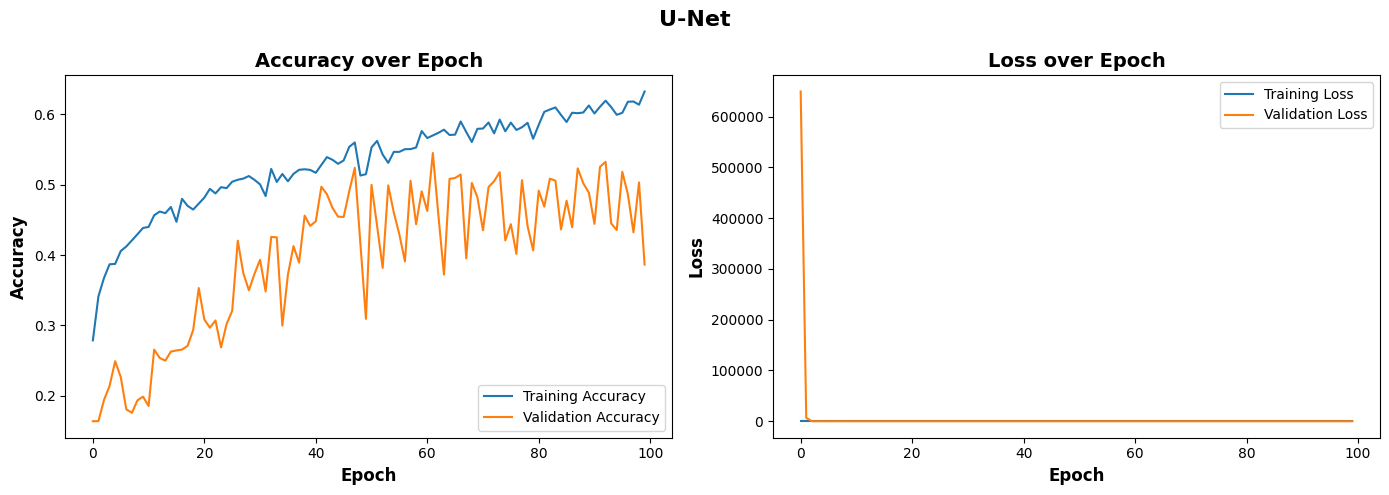

In [26]:
plot_training_history(history_UNet, 'U-Net')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


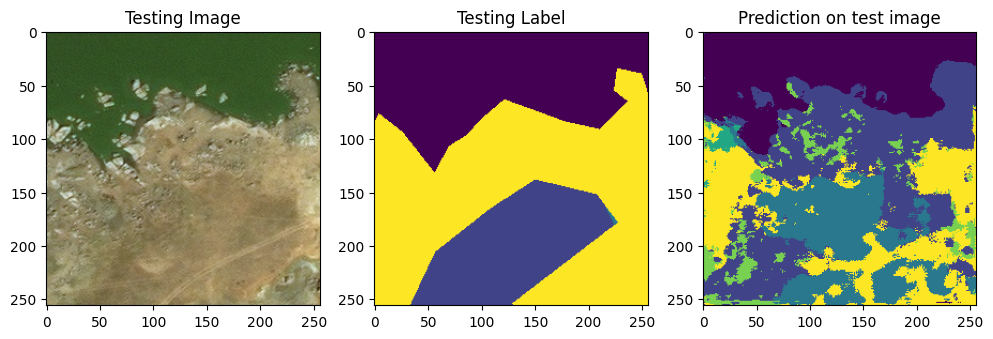

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


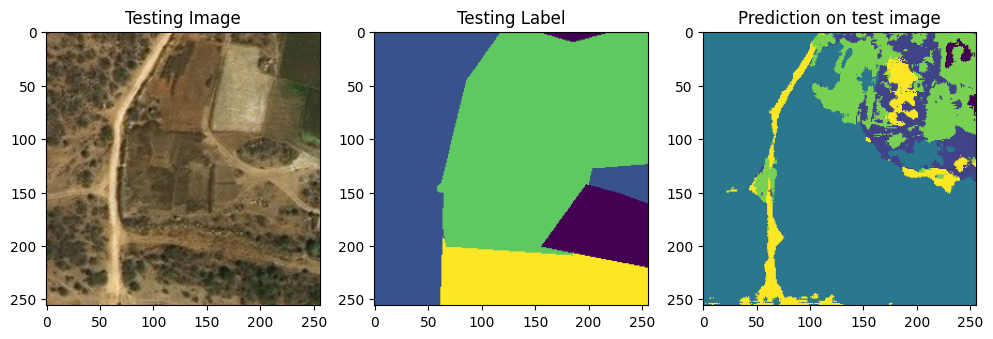

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


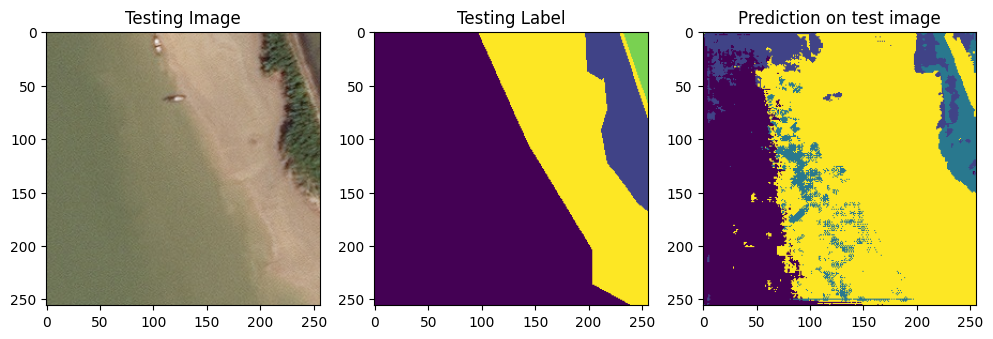

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


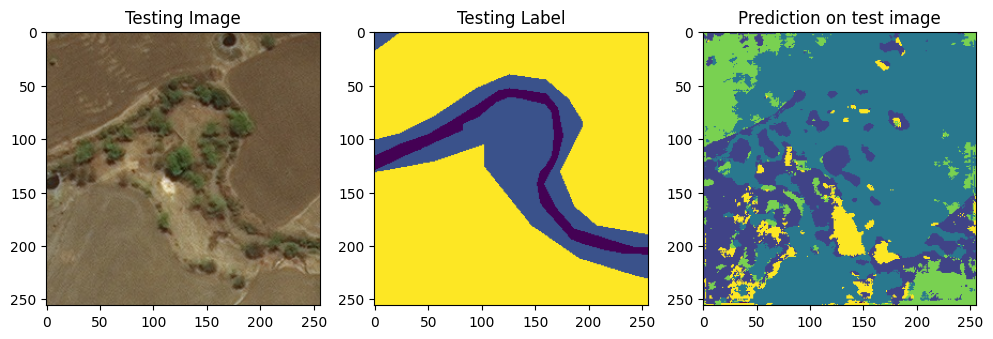

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


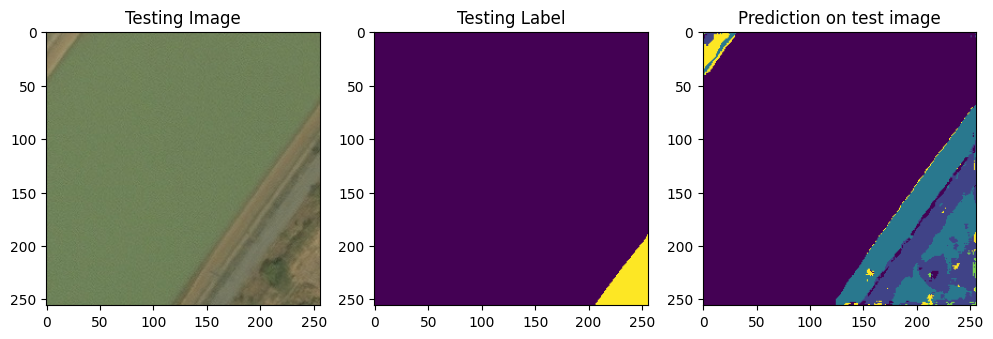

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


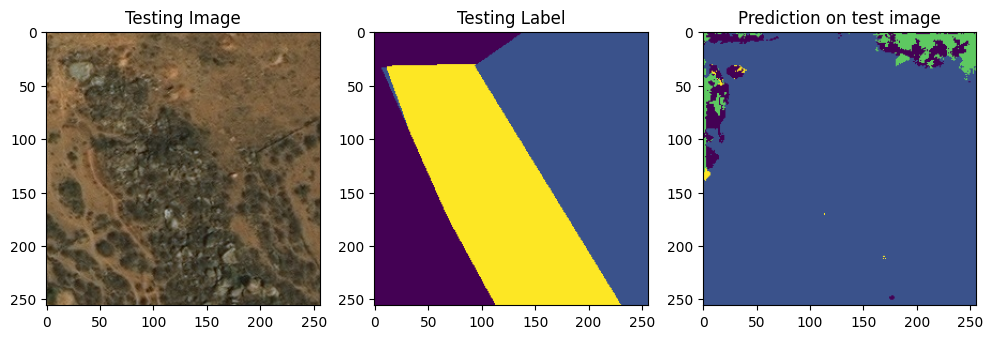

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


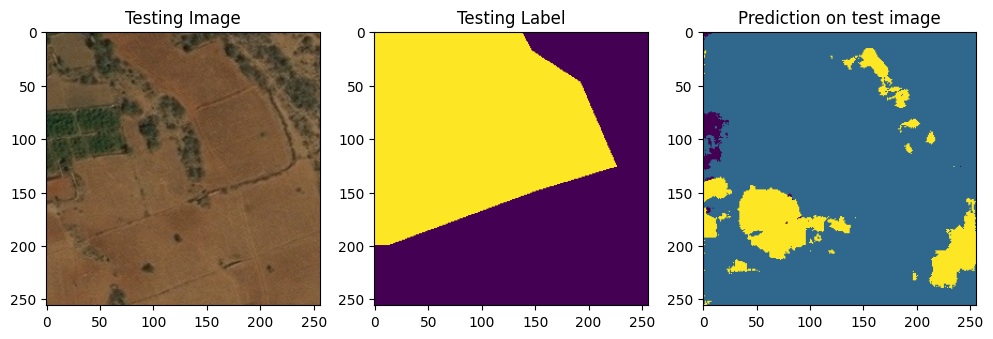

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


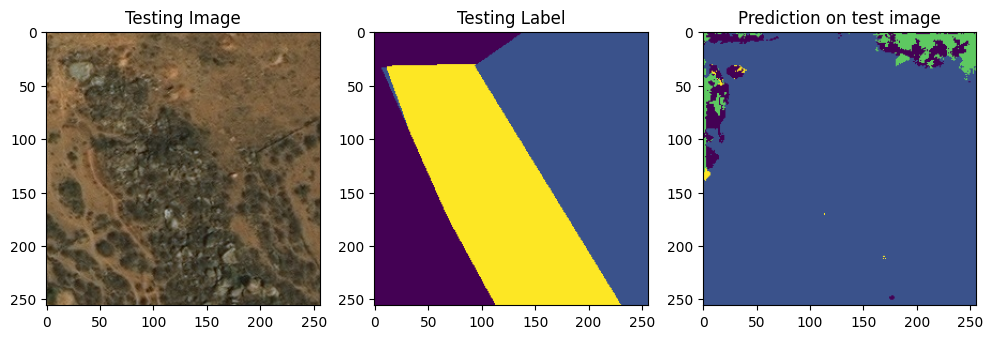

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


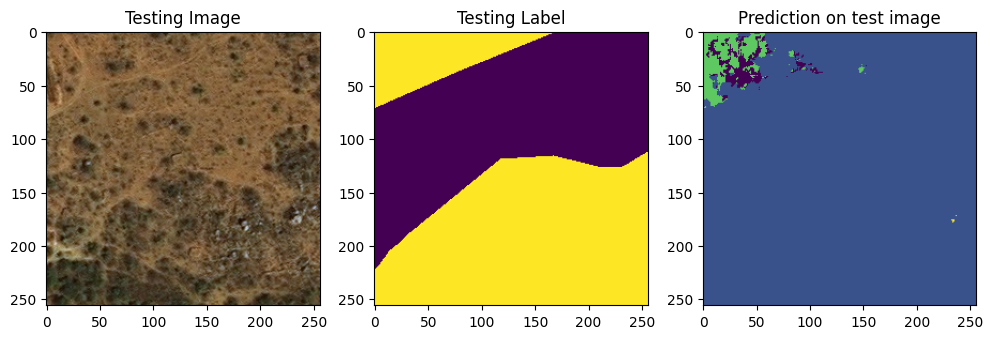

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


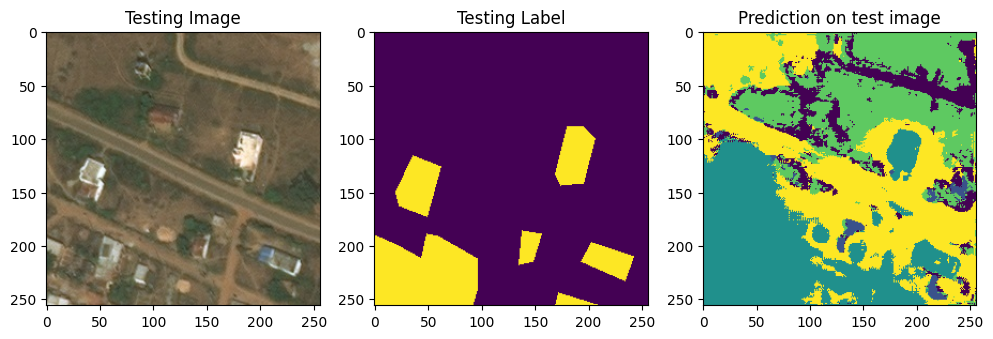

In [32]:
visualize_predictions(model_UNet)

2/2 ━━━━━━━━━━━━━━━━━━━━ 106s 48s/step
Mean IoU : 0.28458688


<ipython-input-19-64668a2d8d8b>:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={'weight': 'bold'})


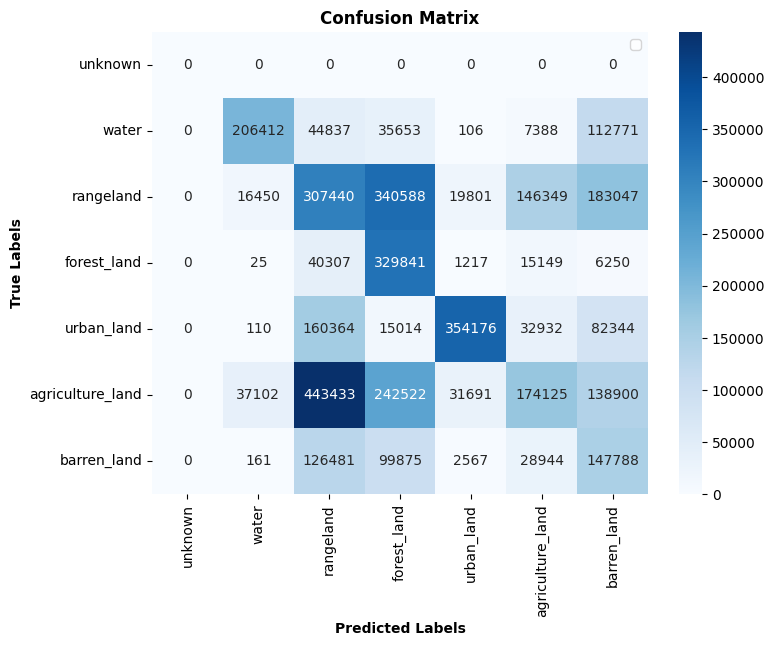

IoU for Class 'unknown' : 0.0000
IoU for Class 'water' : 0.4477
IoU for Class 'rangeland' : 0.1681
IoU for Class 'forest_land' : 0.2928
IoU for Class 'urban_land' : 0.5057
IoU for Class 'agriculture_land' : 0.1341
IoU for Class 'barren_land' : 0.1591


In [28]:
evaluate_model_performance(model_UNet)

In [29]:
model_UNet.save('UNet.h5')